# This notebook analyse the relationship between new sessions (according to our labels) and new labels per day 
(FIGURE 12 of paper)

### Import dataset

In [1]:
from tqdm import tqdm
tqdm.pandas()
import pandas as pd 
predicted_corpus = pd.read_parquet(f"../1.Dataset/Inference_with_predictions/logprecis_predictions.parquet")
predicted_corpus.head(2)

,session_id,sequence_words,sequence_predictions
0,0,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D..."
1,1,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D..."


Concatenate `sequence words` and `sequence_predictions`

In [2]:
predicted_corpus["sessions"] = predicted_corpus["sequence_words"].progress_apply(
                                                lambda split_session: " ".join(split_session))
predicted_corpus["predictions"] = predicted_corpus["sequence_predictions"].progress_apply(
                                                lambda split_prediction: " -- ".join(split_prediction))
predicted_corpus.head(2)

100%|██████████| 233035/233035 [00:01<00:00, 149752.09it/s]


,session_id,sequence_words,sequence_predictions,sessions,predictions
0,0,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D...",enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...
1,1,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D...",enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...


#### How many unique sessions? How many unique predictions?

In [3]:
print(f"Number of unique sessions: {predicted_corpus.sessions.nunique():,}")
print(f"Number of unique predictions: {predicted_corpus.predictions.nunique():,}")

Number of unique sessions: 233,035
Number of unique predictions: 1,673


Load original data

In [4]:
full_corpus = pd.read_csv(f"../1.Dataset/Inference/cyberlab_data.csv")
if "session_id" in full_corpus.columns:
    full_corpus = full_corpus.drop("session_id", axis=1)
full_corpus = full_corpus.reset_index().rename({"index":"session_id"}, axis=1)
full_corpus.head(2)

,session_id,session,sensor,first_timestamp,date
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:11.151186+00:00,2019-06-04
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:50.396610+00:00,2019-06-04


Join with predictions

In [5]:
joined_corpus = full_corpus[["session_id", "first_timestamp", "sensor", "date"]].merge(predicted_corpus[["session_id", "sessions", "predictions"]], on="session_id")
joined_corpus.head(2)

,session_id,first_timestamp,sensor,date,sessions,predictions
0,0,2019-06-04 09:45:11.151186+00:00,eea5dc653b37,2019-06-04,enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...
1,1,2019-06-04 09:45:50.396610+00:00,eea5dc653b37,2019-06-04,enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...


#### Create date attribute

In [6]:
joined_corpus["first_timestamp"] = pd.to_datetime(joined_corpus["first_timestamp"])
joined_corpus["date"] = joined_corpus["first_timestamp"].apply(lambda datetime: datetime.date())
joined_corpus.head(2)

,session_id,first_timestamp,sensor,date,sessions,predictions
0,0,2019-06-04 09:45:11.151186+00:00,eea5dc653b37,2019-06-04,enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...
1,1,2019-06-04 09:45:50.396610+00:00,eea5dc653b37,2019-06-04,enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...


#### Make sure we are handling only unique sessions

In [7]:
print(f"Before dropping duplicates: {joined_corpus.shape[0]}")
joined_corpus.sort_values(by = "first_timestamp", ascending = True, inplace = True)
joined_corpus = joined_corpus.drop_duplicates(["sessions"])
print(f"After dropping duplicates: {joined_corpus.shape[0]}")
joined_corpus.head(2)

Before dropping duplicates: 233035


After dropping duplicates: 233035


,session_id,first_timestamp,sensor,date,sessions,predictions
0,0,2019-06-04 09:45:11.151186+00:00,eea5dc653b37,2019-06-04,enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...
1,1,2019-06-04 09:45:50.396610+00:00,eea5dc653b37,2019-06-04,enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...


#### How long did the collection last?

In [8]:
start = joined_corpus.first_timestamp.min()
stop = joined_corpus.first_timestamp.max()
print(f"Collection started in {start} and lasted untill {stop}")

Collection started in 2019-06-04 09:45:11.151186+00:00 and lasted untill 2020-02-03 10:58:18.717376+00:00


#### Which distribution of unique sessions/day? Group daily stats

In [52]:
# Groupby date and set date as an index
unique_session_per_date = joined_corpus.groupby("date")["sessions"].count().reset_index().rename({"full_session":"unique_sessions_per_day"}, axis = 1).sort_values(by = "date")
unique_session_per_date.set_index(unique_session_per_date.date, inplace = True)
unique_session_per_date.drop("date", axis = 1, inplace = True)
# Now refill dates in which the honeypot was off with None
joined_corpus_dropna = joined_corpus.dropna()
idx = pd.date_range(joined_corpus_dropna.date.min(), joined_corpus_dropna.date.max())
unique_session_per_date = unique_session_per_date.reindex(idx, fill_value=None)
unique_session_per_date.head(2)

,sessions
2019-06-04,82.0
2019-06-05,125.0


For each label, getting the date of first appearance

In [54]:
labels_first_appearances = joined_corpus[["date", "predictions"]].sort_values(by = "date").drop_duplicates(["predictions"])
labels_first_appearances = labels_first_appearances.rename({"date":"first_appearance"}, axis = 1)
labels_first_appearances.head(2)

,first_appearance,predictions
0,2019-06-04,Discovery -- Discovery -- Discovery -- Discove...
59,2019-06-04,Discovery -- Discovery -- Discovery -- Discove...


Now, find the number of unique predictions/day according to the model

In [57]:
# Groupby date and set date as an index
unique_labels_per_date = labels_first_appearances.groupby("first_appearance")["predictions"].nunique().reset_index().rename({"predictions":"new_labels_per_day"}, axis = 1).sort_values(by = "first_appearance")
unique_labels_per_date.set_index(unique_labels_per_date.first_appearance, inplace = True)
unique_labels_per_date.drop("first_appearance", axis = 1, inplace = True)
# Now refill dates in which the honeypot was off with None
idx = pd.date_range(joined_corpus_dropna.date.min(), joined_corpus_dropna.date.max())
unique_labels_per_date = unique_labels_per_date.reindex(idx, fill_value=None)
unique_labels_per_date.head(2)

,new_labels_per_day
2019-06-04,12.0
2019-06-05,8.0


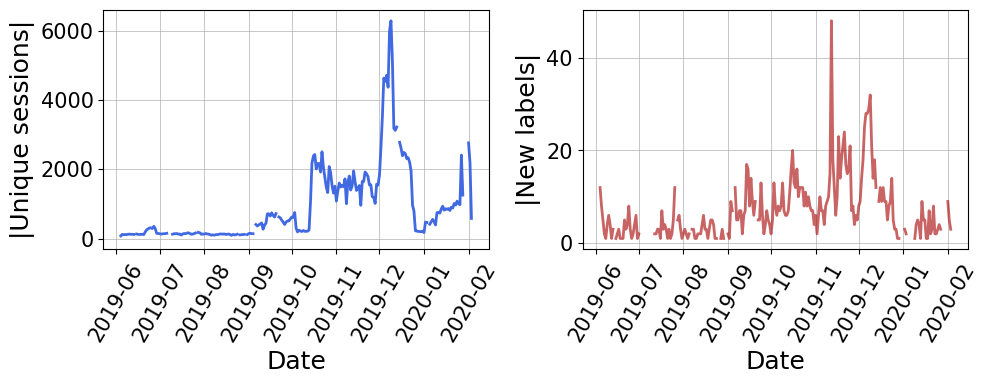

In [59]:
import matplotlib.pyplot as plt 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
fontsize = 15

# First ax
ax1.plot(unique_session_per_date.index, unique_session_per_date.sessions, linewidth = 2, color = "royalblue", label = "|Unique sessions|")
ax1.set_ylabel('|Unique sessions|', fontsize = fontsize + 3)
ax1.yaxis.set_tick_params(labelsize=fontsize)
ax1.set_xlabel('Date', fontsize = fontsize + 3)
ax1.xaxis.set_tick_params(labelsize=fontsize, rotation = 60)  
ax1.grid(linewidth = .5)

# Second ax
ax2.plot(unique_labels_per_date.index, unique_labels_per_date.new_labels_per_day, linewidth = 2, color = "firebrick", label = "|New labels|", alpha = .7)
ax2.set_ylabel('|New labels|', fontsize = fontsize + 3)
ax2.set_xlabel('Date', fontsize = fontsize + 3)
ax2.yaxis.set_tick_params(labelsize=fontsize)
ax2.xaxis.set_tick_params(labelsize=fontsize, rotation = 60)   
ax2.grid(linewidth = .5)

plt.tight_layout()
plt.show()

COMMENT: The plot above shows that we indeed perform an aggregation, moving from ~ 500 unique sessions per day to ~ 30 unique labels per day